<a href="https://colab.research.google.com/github/sensharma/adlproject/blob/main/adlproj_captum_exps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install captum > /dev/null

In [ ]:
import torch, torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, models, transforms

import captum

import os
import pickle
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import DeepLift
from captum.attr import DeepLiftShap
from captum.attr import visualization as viz

### Paths and DataLoaders

In [ ]:
data_path = os.path.join(os.getcwd(), 'gdrive', 'MyDrive', 'data')
models_path = os.path.join(os.getcwd(), 'gdrive', 'MyDrive', 'colabdrive', 'adlproject', 'saved_models')
plots_path = os.path.join(os.getcwd(), 'gdrive', 'MyDrive', 'colabdrive', 'adlproject', 'plots', 'adv_examples')
scores_path = os.path.join(os.getcwd(), 'gdrive', 'MyDrive', 'colabdrive', 'adlproject', 'saved_scores')

use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"

In [ ]:
train_dataset = datasets.MNIST(root=data_path,
                               train=True,
                               download=True,
                               transform=transforms.Compose([
                                                             transforms.ToTensor()
                                                             ])
                               )

test_dataset = datasets.MNIST(root=data_path,
                              train=False,
                              download=True,
                              transform=transforms.Compose([
                                                            transforms.ToTensor()
                                                            ])
                              )

fm_train_dataset = datasets.FashionMNIST(root=data_path,
                                         train=True,
                                         download=True,
                                         transform=transforms.Compose([
                                                                       transforms.ToTensor()
                                                                       ])
                                         )

fm_test_dataset = datasets.FashionMNIST(root=data_path,
                                        train=False,
                                        download=True,
                                        transform=transforms.Compose([
                                                                      transforms.ToTensor()
                                                                      ])
                                        )

mnist_train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=False,
    )

mnist_test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=128,
    shuffle=False,
    )

f_mnist_train_loader = torch.utils.data.DataLoader(
    dataset=fm_train_dataset,
    batch_size=128,
    shuffle=False,
    )

f_mnist_test_loader = torch.utils.data.DataLoader(
    dataset=fm_test_dataset,
    batch_size=128,
    shuffle=False,
    )

In [ ]:
batch_mnist = next(iter(mnist_train_loader))
batch_f_mnist = next(iter(f_mnist_train_loader))

### Defining models and loading trained models

Trained CNN: MNIST and FashionMNIST: Model definition and loading saved model

In [ ]:
class Net(nn.Module):
    def __init__(self, h=28, w=28, n_channels=1):
        super(Net, self).__init__()
        self.h = h
        self.w = w
        self.n_channels = n_channels

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(16, 16), stride=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=(9, 9), stride=(1, 1)),
            nn.ReLU(),
            nn.Dropout(0.25),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(1600, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def x_compat(self, x):
        # print(f"x - type {type(x)}")
        if type(x) is not torch.Tensor:
            x_tensor = torch.from_numpy(x)
        else:
            x_tensor = x
        x_out = x_tensor.clone().reshape(x.shape[0],
                                         self.n_channels,
                                         self.h,
                                         self.w)
        return x_out.float()

    def forward(self, x):
        if x.ndim != 4:
            # print("in compat")
            x = self.x_compat(x)
        x = self.conv_layers(x)
        # print(f"shape: {x.shape}")
        x = x.view(-1, 1600)
        x = self.fc_layers(x)
        return x

In [ ]:
cnn_fmnist_file = f'{models_path}/f_mnist_checkpoint'
cnn_fmnist_checkpoint = torch.load(cnn_fmnist_file, map_location=device)
cnn_fmnist = Net().to(device)
cnn_fmnist.load_state_dict(cnn_fmnist_checkpoint['model_state_dict'])

cnn_fmnist.eval()
with torch.no_grad():
    cnn_fmnist_pred = cnn_fmnist(batch_f_mnist[0][0:1].to(device))
print(cnn_fmnist_pred, torch.sum(cnn_fmnist_pred), torch.max(cnn_fmnist_pred), torch.argmax(cnn_fmnist_pred))

tensor([[4.3204e-11, 3.8927e-10, 1.3588e-12, 3.7035e-08, 3.2536e-12, 2.3034e-04,
         7.8439e-11, 1.3089e-02, 5.2176e-08, 9.8668e-01]]) tensor(1.0000) tensor(0.9867) tensor(9)


In [ ]:
cnn_mnist_file = f'{models_path}/mnist_checkpoint'
cnn_mnist_checkpoint = torch.load(cnn_mnist_file, map_location=device)
cnn_mnist = Net().to(device)
cnn_mnist.load_state_dict(cnn_mnist_checkpoint['model_state_dict'])

cnn_mnist.eval()
with torch.no_grad():
    cnn_mnist_pred = cnn_mnist(batch_mnist[0][0:1].to(device))
print(cnn_mnist_pred, torch.sum(cnn_mnist_pred), torch.max(cnn_mnist_pred), torch.argmax(cnn_mnist_pred))

tensor([[7.1068e-09, 8.7855e-09, 1.6371e-09, 8.9063e-04, 2.4226e-11, 9.9909e-01,
         1.6162e-08, 4.3806e-10, 1.6770e-07, 2.2598e-05]]) tensor(1.) tensor(0.9991) tensor(5)


## FGSM Adversarial example experiments

In [ ]:
with open(f"{scores_path}/adv_ex.pkl", "rb") as fp: # loading saved MNIST adv examples
    ex_load = pickle.load(fp)

In [ ]:
with open(f"{scores_path}/adv_ex_fmnist.pkl", "rb") as fp: # loading saved FashionMNIST adv examples
    ex_load_fmnist = pickle.load(fp)

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
# Structure in loaded data: list(eps_index) -> each -> 20*(Orig_pred, Adv_pred, Adv_data, Orig_data)

### MNIST

I. DeepSHAP

In [ ]:
save = False

<Figure size 432x288 with 0 Axes>

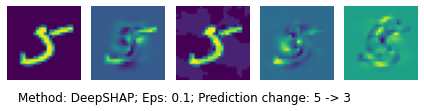

In [ ]:
eps = .1
example_idx = 7

eps_idx = epsilons.index(eps)
orig_pred = ex_load[eps_idx][example_idx][0]
adv_pred = ex_load[eps_idx][example_idx][1]
adv_img = ex_load[eps_idx][example_idx][2]
orig_img = ex_load[eps_idx][example_idx][3]
adv_img_tens = torch.Tensor(adv_img).unsqueeze(0).unsqueeze(0)
orig_img_tens = torch.Tensor(orig_img).unsqueeze(0).unsqueeze(0)

images, labels = next(iter(mnist_test_loader))

method = "DeepSHAP"
explainer = DeepLiftShap(cnn_mnist)
# Computes deeplift attribution scores for class 3.
orig_attr = explainer.attribute(orig_img_tens, target=orig_pred, baselines=images.to(device))
orig_attr = np.transpose(orig_attr.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
adv_attr_self = explainer.attribute(adv_img_tens, target=adv_pred, baselines=images.to(device))
adv_attr_self = np.transpose(adv_attr_self.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
adv_attr_orig = explainer.attribute(adv_img_tens, target=orig_pred, baselines=images.to(device))
adv_attr_orig = np.transpose(adv_attr_orig.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

l_img = [orig_img, orig_attr, adv_img, adv_attr_self, adv_attr_orig]

fig = plt.figure()
fig, axs, = plt.subplots(1, 5)
for count, img in enumerate(l_img):
    axs[count].imshow(img.squeeze())
    axs[count].axis('off')
plt.margins(0)
plt.tight_layout()
textstr = f"Method: {method}; Eps: {eps}; Prediction change: {orig_pred} -> {adv_pred}"
plt.text(0.05, 0.3, textstr, fontsize=12, transform=plt.gcf().transFigure)

if save:
    plt.savefig(f'{plots_path}/mnist_adv_{orig_pred}to{adv_pred}_{eps}_{method}.png', bbox_inches = 'tight', pad_inches = 0)
plt.show()

II. DeepLIFT

<Figure size 432x288 with 0 Axes>

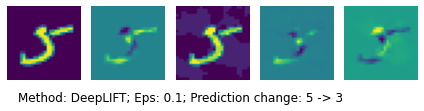

In [ ]:
eps = .1
example_idx = 7

eps_idx = epsilons.index(eps)
orig_pred = ex_load[eps_idx][example_idx][0]
adv_pred = ex_load[eps_idx][example_idx][1]
adv_img = ex_load[eps_idx][example_idx][2]
orig_img = ex_load[eps_idx][example_idx][3]
adv_img_tens = torch.Tensor(adv_img).unsqueeze(0).unsqueeze(0)
orig_img_tens = torch.Tensor(orig_img).unsqueeze(0).unsqueeze(0)

images, labels = next(iter(mnist_test_loader))

method = "DeepLIFT"
explainer = DeepLift(cnn_mnist)
orig_attr = explainer.attribute(orig_img_tens, target=orig_pred)
orig_attr = np.transpose(orig_attr.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
adv_attr_self = explainer.attribute(adv_img_tens, target=adv_pred)
adv_attr_self = np.transpose(adv_attr_self.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
adv_attr_orig = explainer.attribute(adv_img_tens, target=orig_pred)
adv_attr_orig = np.transpose(adv_attr_orig.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

l_img = [orig_img, orig_attr, adv_img, adv_attr_self, adv_attr_orig]

fig = plt.figure()
fig, axs, = plt.subplots(1, 5)
for count, img in enumerate(l_img):
    axs[count].imshow(img.squeeze())
    axs[count].axis('off')
plt.margins(0)
plt.tight_layout()
textstr = f"Method: {method}; Eps: {eps}; Prediction change: {orig_pred} -> {adv_pred}"
plt.text(0.05, 0.3, textstr, fontsize=12, transform=plt.gcf().transFigure)

if save:
    plt.savefig(f'{plots_path}/mnist_adv_{orig_pred}to{adv_pred}_{eps}_{method}.png', bbox_inches = 'tight', pad_inches = 0)
plt.show()

III. Integrated Gradients

<Figure size 432x288 with 0 Axes>

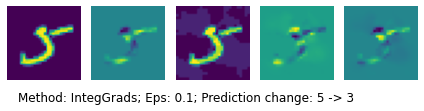

In [ ]:
eps = .1
example_idx = 7

eps_idx = epsilons.index(eps)
orig_pred = ex_load[eps_idx][example_idx][0]
adv_pred = ex_load[eps_idx][example_idx][1]
adv_img = ex_load[eps_idx][example_idx][2]
orig_img = ex_load[eps_idx][example_idx][3]
adv_img_tens = torch.Tensor(adv_img).unsqueeze(0).unsqueeze(0)
orig_img_tens = torch.Tensor(orig_img).unsqueeze(0).unsqueeze(0)

images, labels = next(iter(mnist_test_loader))

method = "IntegGrads"
explainer = IntegratedGradients(cnn_mnist)
orig_attr = explainer.attribute(orig_img_tens, target=orig_pred)
orig_attr = np.transpose(orig_attr.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
adv_attr_self = explainer.attribute(adv_img_tens, target=adv_pred)
adv_attr_self = np.transpose(adv_attr_self.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
adv_attr_orig = explainer.attribute(adv_img_tens, target=orig_pred)
adv_attr_orig = np.transpose(adv_attr_orig.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

l_img = [orig_img, orig_attr, adv_img, adv_attr_self, adv_attr_orig]

fig = plt.figure()
fig, axs, = plt.subplots(1, 5)
for count, img in enumerate(l_img):
    axs[count].imshow(img.squeeze())
    axs[count].axis('off')
plt.margins(0)
plt.tight_layout()
textstr = f"Method: {method}; Eps: {eps}; Prediction change: {orig_pred} -> {adv_pred}"
plt.text(0.05, 0.3, textstr, fontsize=12, transform=plt.gcf().transFigure)

if save:
    plt.savefig(f'{plots_path}/mnist_adv_{orig_pred}to{adv_pred}_{eps}_{method}.png', bbox_inches = 'tight', pad_inches = 0)
plt.show()

### FashionMNIST

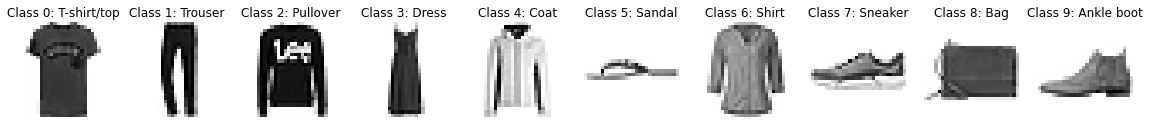

In [ ]:
X_test, y_test = next(iter(f_mnist_test_loader))
class_dict = {0: 'T-shirt/top',
              1: 'Trouser',
              2: 'Pullover',
              3: 'Dress',
              4: 'Coat',
              5: 'Sandal',
              6: 'Shirt',
              7: 'Sneaker',
              8: 'Bag',
              9: 'Ankle boot'
}
samples_fig = plt.figure(figsize=(20, 5))
for i in range(10):
    wh = np.where(y_test==i)[0][0]
    ax = samples_fig.add_subplot(1, 10, i+1)
    ax.set_title(f'Class {i}: {class_dict[i]}')
    plt.imshow(X_test[wh].squeeze()/255, cmap=plt.get_cmap('binary'))
    ax.axis('off')
plt.show()

I. DeepSHAP

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
save = False

<Figure size 432x288 with 0 Axes>

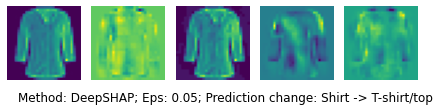

In [ ]:
eps = .05
example_idx = 1

eps_idx = epsilons.index(eps)
orig_pred = ex_load_fmnist[eps_idx][example_idx][0]
adv_pred = ex_load_fmnist[eps_idx][example_idx][1]
adv_img = ex_load_fmnist[eps_idx][example_idx][2]
orig_img = ex_load_fmnist[eps_idx][example_idx][3]
adv_img_tens = torch.Tensor(adv_img).unsqueeze(0).unsqueeze(0)
orig_img_tens = torch.Tensor(orig_img).unsqueeze(0).unsqueeze(0)

images, labels = next(iter(f_mnist_test_loader))

method = "DeepSHAP"
explainer = DeepLiftShap(cnn_fmnist)
# Computes deeplift attribution scores for class 3.
orig_attr = explainer.attribute(orig_img_tens, target=orig_pred, baselines=images.to(device))
orig_attr = np.transpose(orig_attr.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
adv_attr_self = explainer.attribute(adv_img_tens, target=adv_pred, baselines=images.to(device))
adv_attr_self = np.transpose(adv_attr_self.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
adv_attr_orig = explainer.attribute(adv_img_tens, target=orig_pred, baselines=images.to(device))
adv_attr_orig = np.transpose(adv_attr_orig.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

l_img = [orig_img, orig_attr, adv_img, adv_attr_self, adv_attr_orig]

fig = plt.figure()
fig, axs, = plt.subplots(1, 5)
for count, img in enumerate(l_img):
    axs[count].imshow(img.squeeze())
    axs[count].axis('off')
plt.margins(0)
plt.tight_layout()
textstr = f"Method: {method}; Eps: {eps}; Prediction change: {class_dict[orig_pred]} -> {class_dict[adv_pred]}"
plt.text(0.05, 0.3, textstr, fontsize=12, transform=plt.gcf().transFigure)

if save:
    plt.savefig(f'{plots_path}/fmnist_adv_{orig_pred}to{adv_pred}_{eps}_{method}.png', bbox_inches = 'tight', pad_inches = 0)
plt.show()

II. DeepLIFT

<Figure size 432x288 with 0 Axes>

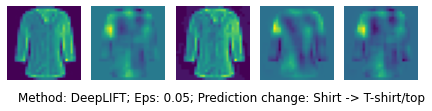

In [ ]:
eps = .05
example_idx = 1

eps_idx = epsilons.index(eps)
orig_pred = ex_load_fmnist[eps_idx][example_idx][0]
adv_pred = ex_load_fmnist[eps_idx][example_idx][1]
adv_img = ex_load_fmnist[eps_idx][example_idx][2]
orig_img = ex_load_fmnist[eps_idx][example_idx][3]
adv_img_tens = torch.Tensor(adv_img).unsqueeze(0).unsqueeze(0)
orig_img_tens = torch.Tensor(orig_img).unsqueeze(0).unsqueeze(0)

images, labels = next(iter(f_mnist_test_loader))

method = "DeepLIFT"
explainer = DeepLift(cnn_fmnist)
# Computes deeplift attribution scores for class 3.
orig_attr = explainer.attribute(orig_img_tens, target=orig_pred)
orig_attr = np.transpose(orig_attr.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
adv_attr_self = explainer.attribute(adv_img_tens, target=adv_pred)
adv_attr_self = np.transpose(adv_attr_self.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
adv_attr_orig = explainer.attribute(adv_img_tens, target=orig_pred)
adv_attr_orig = np.transpose(adv_attr_orig.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

l_img = [orig_img, orig_attr, adv_img, adv_attr_self, adv_attr_orig]

fig = plt.figure()
fig, axs, = plt.subplots(1, 5)
for count, img in enumerate(l_img):
    axs[count].imshow(img.squeeze())
    axs[count].axis('off')
plt.margins(0)
plt.tight_layout()
textstr = f"Method: {method}; Eps: {eps}; Prediction change: {class_dict[orig_pred]} -> {class_dict[adv_pred]}"
plt.text(0.05, 0.3, textstr, fontsize=12, transform=plt.gcf().transFigure)

if save:
    plt.savefig(f'{plots_path}/fmnist_adv_{orig_pred}to{adv_pred}_{eps}_{method}.png', bbox_inches = 'tight', pad_inches = 0)
plt.show()

III. Integrated Gradients

<Figure size 432x288 with 0 Axes>

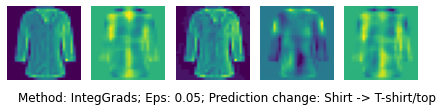

In [ ]:
eps = .05
example_idx = 1

eps_idx = epsilons.index(eps)
orig_pred = ex_load_fmnist[eps_idx][example_idx][0]
adv_pred = ex_load_fmnist[eps_idx][example_idx][1]
adv_img = ex_load_fmnist[eps_idx][example_idx][2]
orig_img = ex_load_fmnist[eps_idx][example_idx][3]
adv_img_tens = torch.Tensor(adv_img).unsqueeze(0).unsqueeze(0)
orig_img_tens = torch.Tensor(orig_img).unsqueeze(0).unsqueeze(0)

images, labels = next(iter(f_mnist_test_loader))

method = "IntegGrads"
explainer = IntegratedGradients(cnn_fmnist)

orig_attr = explainer.attribute(orig_img_tens, target=orig_pred)
orig_attr = np.transpose(orig_attr.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
adv_attr_self = explainer.attribute(adv_img_tens, target=adv_pred)
adv_attr_self = np.transpose(adv_attr_self.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
adv_attr_orig = explainer.attribute(adv_img_tens, target=orig_pred)
adv_attr_orig = np.transpose(adv_attr_orig.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

l_img = [orig_img, orig_attr, adv_img, adv_attr_self, adv_attr_orig]

fig = plt.figure()
fig, axs, = plt.subplots(1, 5)
for count, img in enumerate(l_img):
    axs[count].imshow(img.squeeze())
    axs[count].axis('off')
plt.margins(0)
plt.tight_layout()
textstr = f"Method: {method}; Eps: {eps}; Prediction change: {class_dict[orig_pred]} -> {class_dict[adv_pred]}"
plt.text(0.05, 0.3, textstr, fontsize=12, transform=plt.gcf().transFigure)

if save:
    plt.savefig(f'{plots_path}/fmnist_adv_{orig_pred}to{adv_pred}_{eps}_{method}.png', bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Transfer learning

### Transfer Learning model comparisons

Trained Resnet: FashionMNIST: Model definition and loading saved model

In [ ]:
class TenResNet(nn.Module):
    def __init__(self, in_channels=1):
        super(TenResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        # in original model
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        out_features = self.model.fc.in_features
        self.model.fc = nn.Linear(out_features, 10)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
resnet_model_file = f'{models_path}/f_mnist_res_cpt_conv_chng'
resnet_checkpoint = torch.load(resnet_model_file, map_location=device)
ten_res_model = TenResNet(in_channels=1).to(device)
ten_res_model.load_state_dict(resnet_checkpoint['model_state_dict'])

ten_res_model.eval()
with torch.no_grad():
    pred = ten_res_model(batch_f_mnist[0][0:1].to(device))
    probs = torch.exp(F.log_softmax(pred, dim=1))
print(probs, torch.sum(probs), torch.max(probs), torch.argmax(probs))

tensor([[8.5735e-03, 9.5338e-03, 2.9704e-04, 5.5545e-02, 1.1963e-03, 3.0518e-01,
         3.4557e-01, 5.1028e-02, 2.0794e-01, 1.5135e-02]]) tensor(1.0000) tensor(0.3456) tensor(6)


In [ ]:
def attribute_image_features(algorithm, input_img, **kwargs):
    cnn_mnist.zero_grad()
    tensor_attributions = algorithm.attribute(input_img,
                                              target=labels[ind],
                                              **kwargs
                                             )
    return tensor_attributions

images, labels = next(iter(f_mnist_test_loader))

ind = 3
input_img = images[ind].unsqueeze(0).to(device)
input_img.requires_grad = True

dls_cnn = DeepLiftShap(cnn_fmnist)
attr_dls_cnn = attribute_image_features(dls_cnn, input_img, baselines=images.to(device))
attr_dls_cnn = np.transpose(attr_dls_cnn.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

In [ ]:
def attribute_image_features(algorithm, input_img, **kwargs):
    cnn_mnist.zero_grad()
    tensor_attributions = algorithm.attribute(input_img,
                                              target=labels[ind],
                                              **kwargs
                                             )
    return tensor_attributions

images, labels = next(iter(f_mnist_test_loader))

ind = 3
input_img = images[ind].unsqueeze(0).to(device)
input_img.requires_grad = True

dls_res = DeepLift(ten_res_model)
attr_dls_res = attribute_image_features(dls_res, input_img)
attr_dls_res = np.transpose(attr_dls_res.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

RuntimeError: ignored